In [12]:
!pip install python-mnist

In [13]:
import numpy as np
from mnist.loader import MNIST
from collections import OrderedDict
import matplotlib.pyplot as plt

In [24]:
# utils.py

def smooth_curve(x):
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')

    return y[5:len(y)-5]

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    # 데이터를 뒤섞은 순서만들기
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    # 흑백, 컬러 이미지 구분
    t = t[permutation]

    return x, t

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

def numerical_gradient(self, f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    print(predictions_array)

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.imshow(img.reshape(28, 28), cmap='Greys', interpolation='nearest')

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.1f}% ({})".format(class_names[predicted_label],
                                    10*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 10])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [15]:
# optimizer.py

class GradDescent:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [16]:
# layers.py

class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx
    
class Affine:
    def __init__(self, W, b):
        self.W = W                            # init method에서 input 변수 제외하고는 None  
        self.b = b                           
        self.x = None                         # forward에서 입력되는 값       
        self.dW = None                        # backward에서 입력되는 값 
        self.db = None                        # backward에서 입력되는 값 
         
    def forward(self, x):                     # 순전파
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):                 # 역전파 
        dx = np.dot(dout, self.W.T)           # 그림에서 1번식, W.T => W의 transpose  
        self.dW = np.dot(self.x.T, dout)      # 그림에서 2번식, x.T => x의 transpose
        self.db = np.sum(dout, axis = 0)      # dout array의 세로값을 sum한 값 
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def cross_entropy_error(self, y, t):   # y, t : 배치 입력
        if y.ndim == 1:   # .dim -> numpy 배열의 차원 구하기, 1차원 배열이면
            t = t.reshape(1, t.size) # 2차원 배열로 바꾸기
            y = y.reshape(1, y.size)
                                                     
        if t.size == y.size:
            t = t.argmax(axis=1)
                                                             
        batch_size = y.shape[0]      # 행 갯수 확인 -> 배치 사이즈
        return -np.sum(np.log(y[np.arange(batch_size),t] + 1e-7)) / batch_size

    def softmax(self, x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0) 
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T  # 행렬 원래대로 전치
                                                             
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))    
        
    def forward(self, x, t):
        self.t = t
        self.y = self.softmax(x)
        self.loss = self.cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)
            
        dx = dx.reshape(*self.input_shape)
        
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg: # 학습 시
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # *: 튜플을 다중 입력 인자로 풀어냄(unpack)
            # ex) x.shape => (2,3)
            # ex) np.random.rand(x.shape) => np.random.rand((2,3))
            # ex) np.random.rand(*x.shape) => np.random.rand(2,3)
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [17]:
# trainer.py

class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size

        # optimzer
        optimizer_class_dict = {'sgd':SGD,'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        
        if self.verbose: 
            print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
                            
            train_acc = self.network.accuracy(self.x_train, self.t_train)
            test_acc = self.network.accuracy(self.x_test, self.t_test)
            
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: 
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")

        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [18]:
# multi_layer_net.py

class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_batchnorm=False, use_dropout=False, dropout_ratio=0.5):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화"""
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False): # train_flg 추가
        for key, layer in self.layers.items(): # key와 layer 추출
            if "BatchNorm" in key or "Dropout" in key:  # 학습 및 추론 구별
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)

        weight_decay = self.weight_decay_lambda
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = self.numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        self.loss(x, t, train_flg=True) # train_flg 추가
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


batch : 10 optimizer : sgd overfit : None
train_acc : 0.9566666666666667 val_acc : 0.7535
batch : 10 optimizer : sgd overfit : batchnorm
train_acc : 1.0 val_acc : 0.7728
batch : 10 optimizer : sgd overfit : weightdecay
train_acc : 0.8666666666666667 val_acc : 0.732
batch : 10 optimizer : adam overfit : None
train_acc : 0.41 val_acc : 0.3701
batch : 10 optimizer : adam overfit : batchnorm
train_acc : 0.97 val_acc : 0.7147
batch : 10 optimizer : adam overfit : weightdecay
train_acc : 0.10333333333333333 val_acc : 0.1
batch : 100 optimizer : sgd overfit : None
train_acc : 0.8133333333333334 val_acc : 0.6951
batch : 100 optimizer : sgd overfit : batchnorm
train_acc : 0.9933333333333333 val_acc : 0.7649
batch : 100 optimizer : sgd overfit : weightdecay
train_acc : 0.65 val_acc : 0.5983
batch : 100 optimizer : adam overfit : None
train_acc : 0.86 val_acc : 0.6716
batch : 100 optimizer : adam overfit : batchnorm
train_acc : 0.9566666666666667 val_acc : 0.734
batch : 100 optimizer : adam overf

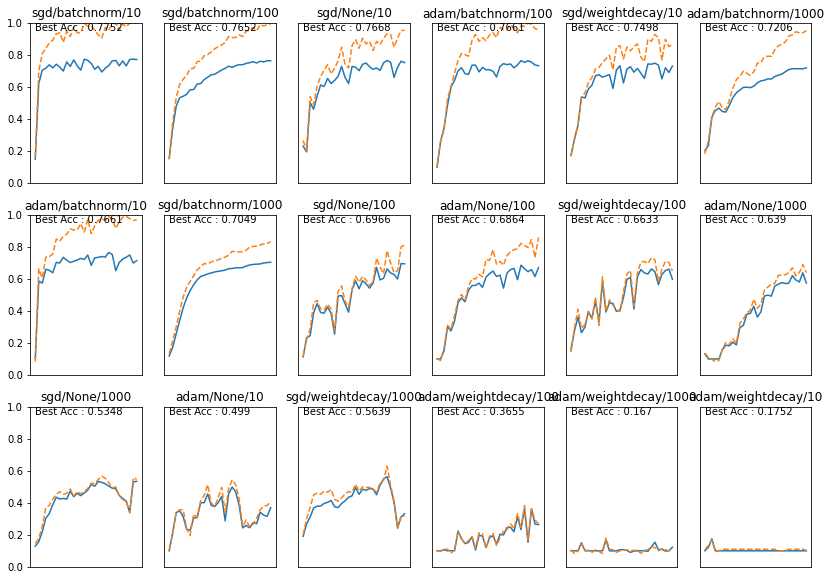

In [19]:
# main.py

x_train, t_train = load_mnist('./', kind='train')
x_test, t_test = load_mnist('./', kind='t10k')

train_size = x_train.shape[0]
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay = 0.1

batches = [10, 100, 1000]
opts = ['sgd', 'adam']
overfits = [None, 'batchnorm', 'weightdecay']

results_val = {}
results_train = {}

for batch in batches:
    for opt in opts:
        for overfit in overfits:
            if overfit == None:
                network = MultiLayerNet(input_size=784, hidden_size_list=[512, 256, 128], output_size=10,
                            activation='relu', weight_init_std=0.01, weight_decay_lambda=0,
                            use_batchnorm=False, use_dropout=False, dropout_ratio=0.5)
                trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                epochs=30, mini_batch_size=batch,
                                optimizer=opt, optimizer_param={'lr': 0.01}, verbose=False)
                trainer.train()
                overfit = "None"
            elif overfit == "batchnorm":
                network = MultiLayerNet(input_size=784, hidden_size_list=[512, 256, 128], output_size=10,
                            activation='relu', weight_init_std=0.01, weight_decay_lambda=0,
                            use_batchnorm=True, use_dropout=False, dropout_ratio=0.5)
                trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                epochs=30, mini_batch_size=batch,
                                optimizer=opt, optimizer_param={'lr': 0.01}, verbose=False)
                trainer.train()
            elif overfit == "weightdecay":
                network = MultiLayerNet(input_size=784, hidden_size_list=[512, 256, 128], output_size=10,
                            activation='relu', weight_init_std=0.01, weight_decay_lambda=0.1,
                            use_batchnorm=False, use_dropout=False, dropout_ratio=0.5)
                trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                epochs=30, mini_batch_size=batch,
                                optimizer=opt, optimizer_param={'lr': 0.01}, verbose=False)
                trainer.train()
            train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list
            print("batch : " + str(batch) + " optimizer : " + opt + " overfit : " + str(overfit))
            print("train_acc : " + str(train_acc_list[-1]) + " val_acc : " + str(test_acc_list[-1]))

            key = opt + "/" + overfit + "/" + str(batch)
            results_val[key] = test_acc_list
            results_train[key] = train_acc_list

plt.rcParams["figure.figsize"] = (14,10)

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 18
col_num = 6
row_num = 3
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    plt.subplot(row_num, col_num, i+1)
    plt.title(key)
    plt.ylim(0.0, 1.0)
    if i % 6: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    maxValue = max(results_val[key])

    plt.text(0, 0.95, "Best Acc : " + str(maxValue))
    plt.plot(x, results_val[key])
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

[-0.75552382 -1.03756725 -1.0476204  -0.71742691 -1.39122116  0.26789551
 -1.46565603  1.44268167  0.23576541  4.32454817]
[-0.68417646 -0.4575741   4.93732247  0.39316612 -0.06522158 -1.7138253
 -0.48358317 -0.63244516 -1.07390738 -0.4763621 ]
[-0.06768289  8.37426102 -0.47520148  0.16485892 -1.51580337 -0.65344772
 -1.18928171 -1.69512907 -1.51136693 -1.12251075]
[-1.14196763  9.41525943 -0.62035683  1.29317019 -1.41382928 -0.66471059
 -1.74385419 -1.56063989 -2.1239929  -0.94924537]
[ 0.98575832 -1.20631807  0.46634333 -0.33978002 -0.24957897 -0.65202437
  3.49206333 -0.84518609 -0.81859571 -0.75861225]


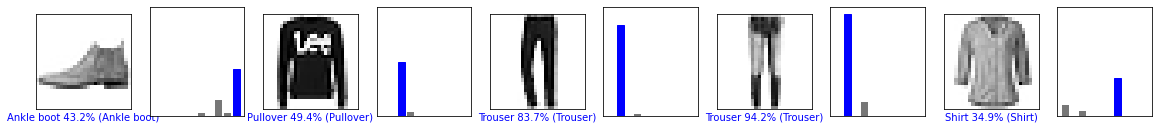

In [27]:
# test with best model

test_network = MultiLayerNet(input_size=784, hidden_size_list=[512, 256, 128], output_size=10, 
                             activation='relu', weight_init_std=0.01, weight_decay_lambda=0, 
                             use_batchnorm=True, use_dropout=False, dropout_ratio=0.5)
trainer = Trainer(test_network, x_train, t_train, x_test, t_test, epochs=30, mini_batch_size=10, 
                  optimizer="sgd", optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

test_data, _ = load_mnist('./', kind='t10k')

predictions = test_network.predict(test_data)

num_rows = 1
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, _, test_data)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, _)
plt.show()
